In [1]:
import torch
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use(['notebook'])
import seaborn as sns
import pkbar
import time
import random

import tensorly as tl
from tensorly.decomposition import matrix_product_state, parafac
from tensorly.mps_tensor import mps_to_tensor
from tensorly.base import unfold, fold
from tensorly.kruskal_tensor import kruskal_to_tensor
tl.set_backend('pytorch')

import tensornetwork as tn
from tensornetwork import contractors
backend = 'pytorch'

In [2]:
s, a = 25, 4

# states: scan from left to right
# actions: left, right, top, down

R = torch.zeros((s, a)) 
for i in range(s):
    if i % 5 == 0:
        R[i, 0] = -1
    if (i - 4) % 5 == 0:
        R[i, 1] = -1
    if i in range(5):
        R[i, 2] = -1
    if i in range(s - 5, s):
        R[i, 3] = -1
R[1, :] = 10
R[3, :] = 5

R_vec = R.reshape(s * a)

In [3]:
# s_t, a, s_(t+1)
P = torch.zeros((s, a, s)) 
for i in range(s):
    if i % 5 == 0:
        P[i, 0, i] = 1
    if (i - 4) % 5 == 0:
        P[i, 1, i] = 1
    if i in range(5):
        P[i, 2, i] = 1
    if i in range(s - 5, s):
        P[i, 3, i] = 1    

    for j in range(s):
        if j == i - 1:
            P[i, 0, j] = 1
        if j == i + 1:
            P[i, 1, j] = 1
        if j == i - 5:
            P[i, 2, j] = 1
        if j == i + 5:
            P[i, 3, j] = 1
    if i == 1:        
        P[i, :, :] = 0
        P[i, :, 21] = 1
    if i == 3:
        P[i, :, :] = 0
        P[i, :, 13] = 1

In [4]:
P_mat = torch.empty((s, a, s, a))
for ss in range(s):
    for i in range(a):
        P_mat[:, :, ss, i] = P[:, :, ss]
P_mat = P_mat.reshape(s * a, s * a)

In [5]:
target = torch.tensor(
 [[21.97748529, 24.4194281, 21.97748529, 19.4194281, 17.47748529],
 [19.77973676, 21.97748529, 19.77973676, 17.80176308, 16.02158677],
 [17.80176308, 19.77973676, 17.80176308, 16.02158677, 14.4194281],
 [16.02158677, 17.80176308, 16.02158677, 14.4194281, 12.97748529],
 [14.4194281, 16.02158677, 14.4194281, 12.97748529, 11.67973676]])

In [6]:
class K_Spin(object):
    
    def __init__(self, s_size, a_size, k, data=None, mode='combined'):
        '''
        args: 
            s_size: the cardinality of the state space
            a_size: the cardinality of the action space
            k: the number of interacting states
        '''
        super(K_Spin, self).__init__()
        self.k = k
        self.s_size = s_size
        self.a_size = a_size
        self.mode = mode
    
        if data is not None:
            self.leaf = data
        else:
            self.leaf = torch.randn((s_size * a_size, 1))
            self.leaf.requires_grad = True
                
        self.data = self.softmax_by_state()
        self.qubits = self.create_qubits()
        self.outer_product_chain()

    
    def softmax_by_state(self):
        '''
        returns:
            updated data tensor after doing a softmax operation
            with regard to each of the states
        '''
        states = []
        softmax = torch.nn.Softmax(dim=0)
        for s in range(self.s_size):
            state = self.leaf[s * self.a_size : (s+1) * self.a_size, :]
            states.append(softmax(state))
        
        cat = torch.cat(states, dim=0) 
        if self.mode == 'combined':
            return cat / torch.sum(cat)
        else:
            return cat
        
        
    def outer_product_chain(self):
        '''
        modifies:
            connects the qubits into a tensor network that
            computes the outer product when contracted
        '''
        if self.k == 1:
            return
        self.qubits[0][1] ^ self.qubits[1][1]
        for k in range(1, self.k - 1):
            self.qubits[k][2] ^ self.qubits[k + 1][1]


    def create_qubits(self):
        '''
        returns:
            a list of qubits (nodes) with suitable dimensions
            (may contain dummy dimensions)
        '''
        qubits = []
        backend = 'pytorch'
        for i in range(self.k):
            if i == 0 or i == self.k - 1:
                q = tn.Node(self.data, backend=backend)
            else:
                q = tn.Node(self.data.unsqueeze(-1), backend=backend)
            qubits.append(q)
        return qubits

In [7]:
def initialize_H(k, P_mat, R_vec, s, a, gamma=0.9):
    
    h = torch.zeros([s * a] * k, dtype=torch.float32)
    
    pbar = pkbar.Pbar(name='initialize H, k='+str(k), target=(s * a))
    for i in range(s * a):
        pbar.update(i)
        in_edge = torch.sum(P[..., i // a])
        
        if k == 1:
            h[i] = 1

        if k == 2:
            for j in range(s * a):
                h[i, j] = P_mat[i, j]
                
        if k == 3:
            for j in range(s * a):
                for l in range(s * a):
                    h[i, j, l] = P_mat[i, j] * P_mat[j, l]
                    
        if k == 4:
            for j in range(s * a):
                for l in range(s * a):
                    for m in range(s * a):
                        h[i, j, l, m] = P_mat[i, j] * P_mat[j, l] * P_mat[l, m]
                        
        h[i, ...] *= in_edge
        
    for n in range(s * a):
        h[..., n] *= R_vec[n]
        
    h.requires_grad = False
    return tn.Node(h * gamma ** (k - 1), backend=backend)

In [8]:
def put_mps(tensors):
    '''
    returns
        a set of tensor cores connected in MPS
        a set of connected edges
    '''
    mps = []
    for i in range(len(tensors)):
        mps.append(tn.Node(tensors[i].detach().clone(), backend=backend))
    
    if len(tensors) == 1:
        return mps, []
    
    connected_edges = []
    conn = mps[0][1] ^ mps[1][0]
    for k in range(1, len(tensors)-1):
        conn = mps[k][2] ^ mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges


def put_cp(factors):
    '''
    returns
        a set of tensor cores connected in cp
        a set of connected edges
    '''
    cp = []
    for f in factors:
        cp.append(tn.Node(f.detach().clone(), backend=backend))
    
    chi = factors[0].shape[1]
    core = torch.zeros([chi] * len(factors))
    for i in range(chi):
        index = tuple([i] * len(factors))
        core[index] = 1
    core = tn.Node(core, backend=backend)
    cp.append(core)
    
    connected_edges = []
    for k in range(len(factors)):
        conn = cp[k][1] ^ core[k]
        connected_edges.append(conn)

    return cp, connected_edges

In [9]:
def fill_dims(tensor, dim):
    N = tensor.shape[0]
    order = len(tensor.shape)
    if order == dim:
        return tensor
    pad = torch.zeros([N] * dim, dtype=torch.float32)
    for i in range(N ** order):
        index = np.unravel_index(i, tensor.shape)
        pad[index] = tensor[index]      
    return pad

In [10]:
def build_networks(five_tuple, k, chi, omega, mode='cp'):
    
    s, a, P, R, gamma = five_tuple
    data = torch.zeros((s * a, 1), requires_grad=True)
    H = torch.randn([s * a] * k, dtype=torch.float32)
    for i in range(k):
        Hi = initialize_H(i + 1, P, R, s, a, gamma=gamma)
        H += fill_dims(Hi.get_tensor(), k)
        
    H *= omega
    
    if mode == 'cp':
        [core, factors], error = parafac(H, chi, n_iter_max=20, init='svd', 
                                         return_errors=True, mask=omega)
        combined_cores, _ = put_cp(factors)
        
    if mode == 'mps':
        tensors = matrix_product_state(H, chi)
        tensors[0] = tensors[0].squeeze(0)
        tensors[-1] = tensors[-1].squeeze(-1)
        combined_cores, _ = put_mps(tensors)
        error = None
    
    if mode == 'full':
        combined_cores = [tn.Node(H, backend=backend)]
        error = None
        
    return H, combined_cores, data, error

In [11]:
def explore_env(trajectories, k, R, P, s, a):
    seen = []
    omega = torch.zeros([s * a] * k)
    for t in range(trajectories):
        indices = torch.empty(2 * k)
        s_curr = np.random.randint(s)
        for num in range(2 * k):
            a_curr = np.random.randint(a)
            if (s_curr, a_curr) in seen:
                a_curr = np.random.randint(a)
            s_next = torch.argmax(P[s_curr, a_curr])
            indices[num] = s_curr * a + a_curr
            seen.append((s_curr, a_curr))
            s_next = s_curr
        for r in range(k):
            index = tuple(indices[r : r + k].to(int))
            omega[index] = 1
    return omega

In [12]:
def variational_train(five_tuple, k, data, combined_cores, lr=0.02, epochs=5000):
    energy_history = []
    Pbar = pkbar.Pbar(name='progress', target=epochs)
    op = optim.SGD([data], lr=lr, momentum=0.9, weight_decay=5e-4)

    for e in range(epochs):
        op.zero_grad()

        new_edges = []
        new_cores = tn.replicate_nodes(combined_cores)
        for j in range(len(combined_cores)):
            edges = new_cores[j].get_all_dangling()
            for edge in edges:
                new_edges.append(edge)

        spin = K_Spin(s, a, k, data=data)
        for j in range(k):
            new_edges[j] ^ spin.qubits[j][0]

        energy = -contractors.branch(tn.reachable(new_cores[0]), nbranch=2).get_tensor()
        energy.backward()
        energy_history.append(energy)

        op.step()
        Pbar.update(e)
        
    return spin, energy_history

In [13]:
def explore(Q, a, eps, ss):
    choice = np.random.uniform()
    if choice < eps:
        return np.random.randint(a)
    else:
        return np.argmax(Q[ss])

def Q_learning(five_tuple, lr=0.05, epochs=5000, gamma=0.5):
    Q_history = []
    Q = np.zeros((s, a))
    ss = np.random.randint(s)
    aa = np.random.randint(a)
    
    for _ in range(epochs):    
        Q_history.append(np.sum(Q))
        new_s = np.argmax(P[ss, aa])
        Q[ss, aa] += lr * (R[ss, aa] + gamma * np.max(Q[new_s, :]) - Q[ss, aa])
        ss = new_s.item()
        aa = explore(Q, a, 0.2, ss)
            
    return Q, Q_history

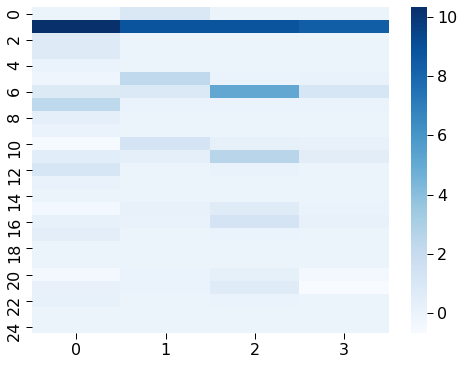

In [246]:
Q, Q_hist = Q_learning(five_tuple)
ax = sns.heatmap(Q, cmap="Blues")
plt.show()

In [247]:
policy = torch.empty(s)
p = torch.tensor(Q)
for i in range(s):
    policy[i] = torch.argmax(p[i, :])
policy.reshape(5, 5)

tensor([[1., 0., 0., 0., 0.],
        [1., 2., 0., 0., 0.],
        [1., 2., 0., 0., 0.],
        [2., 2., 0., 0., 0.],
        [2., 2., 0., 0., 3.]])

CPU times: user 6.6 s, sys: 33.2 ms, total: 6.63 s
Wall time: 6.68 s


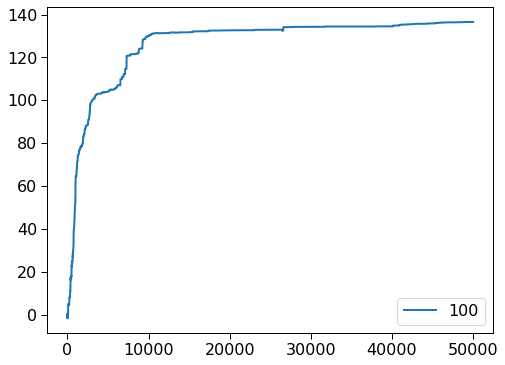

In [266]:
Q, Q_hist = Q_learning(five_tuple, lr=0.5, epochs=50000)
plt.plot(Q_hist)
plt.legend()

In [63]:
k = 3
s, a = 25, 4
gamma = 0.9
chi = 10
omega = explore_env(10000, k, R, P, s, a)
# omega = torch.ones([s * a] * k)
five_tuple = s, a, P_mat, R_vec, gamma 

In [64]:
H, cores, data, error = build_networks(five_tuple, k, chi, omega, mode='cp')

initialize H, k=1
100/100  [==============================] - 0.1s
initialize H, k=2
100/100  [==============================] - 0.2s
initialize H, k=3
100/100  [==============================] - 15.4s


In [65]:
spin, energy_history = variational_train(five_tuple, k, data, cores, lr=0.02, epochs=10000)

progress
10000/10000  [==============================] - 47.9s


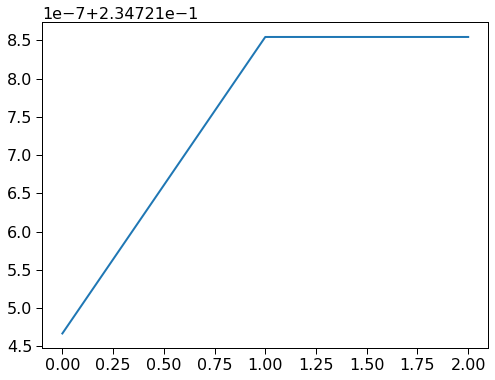

In [66]:
plt.plot(error)

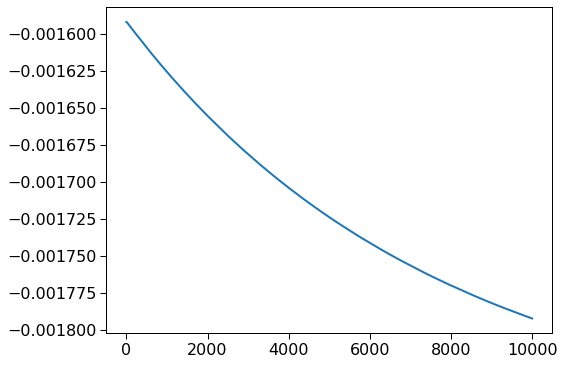

In [67]:
plt.plot(energy_history)

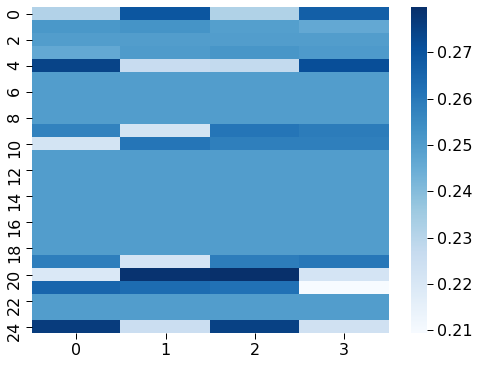

In [68]:
result = spin.data.reshape(s, a).detach().numpy() * 25
ax = sns.heatmap(result, cmap="Blues")
plt.xlabel = 'States'
plt.show()

In [69]:
policy = torch.empty(s)
p = torch.tensor(result)
for i in range(s):
    policy[i] = torch.argmax(p[i, :])
policy.reshape(5, 5)

tensor([[1., 1., 3., 2., 0.],
        [3., 3., 3., 3., 2.],
        [1., 3., 3., 3., 1.],
        [3., 3., 3., 3., 3.],
        [2., 0., 3., 2., 0.]])

In [62]:
d = np.array([[15, 12, 9, 9, 8, 7, 6, 3, 1, 0], 
             [23, 18, 12, 8, 7, 7, 7, 3, 2, 0]])
d = (25 - d) / 25 * 100
h_axis = (np.array(range(10)) + 1) * 10

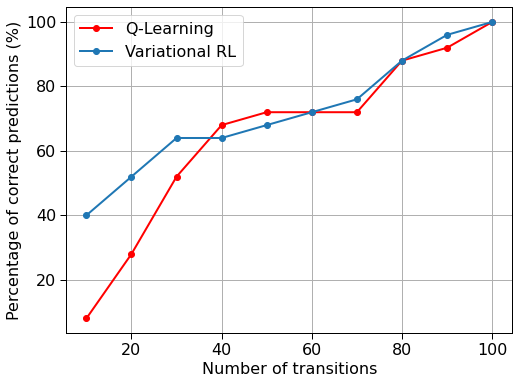

In [63]:
fig = plt.figure()

plt.plot(h_axis, d[1], marker='o', label='Q-Learning', color='r')
plt.plot(h_axis, d[0], marker='o', label='Variational RL')
# plt.xlabel('Percentage')
plt.ylabel('Percentage of correct predictions (%)')
plt.xlabel('Number of transitions')
plt.legend()
plt.grid()
plt.show()
fig.savefig('v_vs_q.png')

In [61]:
x = torch.ones(300, 300)
for i in range(300):
    for j in range(300):
        x[i, j] *= abs(i - 150) + abs(j - 150)
x = -x

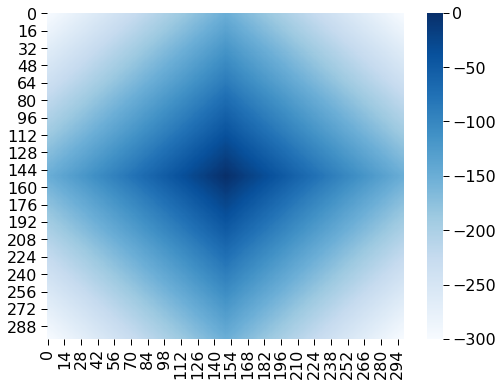

In [62]:
ax = sns.heatmap(x, cmap="Blues")
plt.xlabel = 'States'
plt.show()

In [276]:
H = []
H_core = []
data = torch.zeros((s * a, 1), requires_grad=True)
for i in range(k):
    H.append(initialize_H(i + 1, P_mat, R_vec, s, a, gamma=0.5))
    H_core.append([H[i]])

initialize H, k=1
100/100  [==============================] - 0.1s
initialize H, k=2
100/100  [==============================] - 0.2s
initialize H, k=3
100/100  [==============================] - 3.0s


In [277]:
lr = 0.0001
energy_history = []
epochs = int(5e4)
Pbar = pkbar.Pbar(name='progress', target=epochs)

op = optim.SGD([data], lr=lr, momentum=0.9, weight_decay=5e-4)
for e in range(epochs):
    spins = []
    core = []
    edge = []
    energy = 0
    op.zero_grad()
    
    for i in range(k):
        core.append(tn.replicate_nodes(H_core[i]))
        edge.append([])
        for j in range(len(core[i])):
            edge[i] += core[i][j].get_all_dangling()
    
    for i in range(k):
        spins.append(K_Spin(s, a, i + 1, data=data, mode='distributed'))
        for j in range(i + 1):
            edge[i][j] ^ spins[i].qubits[j][0]
            
    for i in range(k):
        energy -= contractors.branch(tn.reachable(core[i]), nbranch=1).get_tensor()
    energy.backward()
    energy_history.append(-energy)
    
    op.step()
    Pbar.update(e)

progress
50000/50000  [==============================] - 438.0s


TypeError: 'str' object is not callable

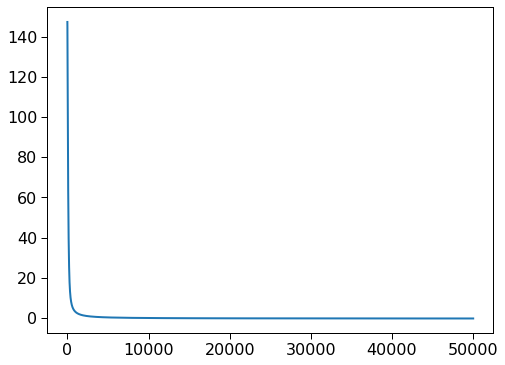

In [252]:
plt.plot(np.array([141.]) - np.array(energy_history))
plt.xlabel('Number of iterations')
plt.ylabel('Energy')

In [263]:
energy_history[-1]

tensor([150.9522], grad_fn=<NegBackward>)

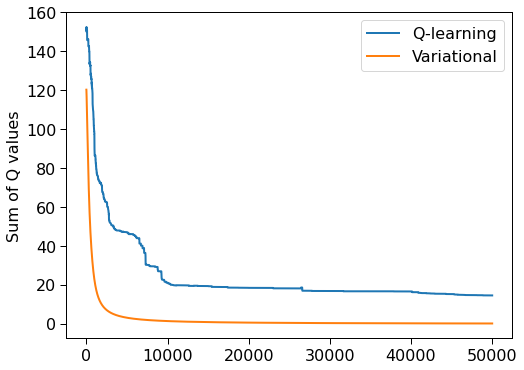

In [279]:
fig = plt.figure()

plt.plot(np.array([151.]) - np.array(Q_hist), label='Q-learning')
plt.plot(np.array([151.]) - np.array(e_hundred), label='Variational')
#plt.xlabel('Number of iterations')
plt.ylabel('Sum of Q values')
plt.legend()

In [274]:
e_hundred = energy_history

In [519]:
o = explore_env(10000, 3, R, P, s, a)
torch.sum(o)

tensor(1600.)